In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from IPython.display import Markdown, display
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, fbeta_score, f1_score, recall_score, precision_score, classification_report

# Data Preprocessing

In [3]:
data=pd.read_csv("data.csv")

In [5]:
def remove_outliers(df):
    # Create a copy of the original DataFrame to avoid modifying it directly
    cleaned_data = df.copy()

    # Iterate over each column in the DataFrame
    for col in cleaned_data.columns:
        # Process only numerical columns (integer or float types)
        if cleaned_data[col].dtype in ['float64', 'int64']:

            # Calculate the first (Q1) and third (Q3) quartiles
            Q1 = cleaned_data[col].quantile(0.25)
            Q3 = cleaned_data[col].quantile(0.75)

            # Compute the Interquartile Range (IQR)
            IQR = Q3 - Q1

            # Define the lower and upper bounds for outlier detection
            lower_limit = Q1 - 1.5 * IQR
            upper_limit = Q3 + 1.5 * IQR

            # Replace outliers with None (NaN)
            cleaned_data[col] = cleaned_data[col].apply(
                lambda x: x if pd.isnull(x) or (lower_limit <= x <= upper_limit) else None
            )

    return cleaned_data

# Apply the outlier removal function to the dataset
df = remove_outliers(data)

In [7]:
# Calculate the percentage of missing (null) values in each column
percent_nulos = data.isnull().mean() * 100

# Print the percentage of missing values for each column
print(percent_nulos)

id                           0.0
diagnosis                    0.0
radius_mean                  0.0
texture_mean                 0.0
perimeter_mean               0.0
area_mean                    0.0
smoothness_mean              0.0
compactness_mean             0.0
concavity_mean               0.0
concave points_mean          0.0
symmetry_mean                0.0
fractal_dimension_mean       0.0
radius_se                    0.0
texture_se                   0.0
perimeter_se                 0.0
area_se                      0.0
smoothness_se                0.0
compactness_se               0.0
concavity_se                 0.0
concave points_se            0.0
symmetry_se                  0.0
fractal_dimension_se         0.0
radius_worst                 0.0
texture_worst                0.0
perimeter_worst              0.0
area_worst                   0.0
smoothness_worst             0.0
compactness_worst            0.0
concavity_worst              0.0
concave points_worst         0.0
symmetry_w

In [9]:
def fill_missing_values(data):
    for column in df.columns:
        if data[column].dtype == 'object':
            df[column] = df[column].fillna(df[column].mode()[0])  # Fill with mode
        else:
            df[column] = df[column].fillna(df[column].mean())  # Fill with mean
    return df

df = fill_missing_values(data)

In [11]:
df.drop(columns=['id', 'Unnamed: 32'], inplace=True)

In [13]:
#convert categorical data into numerical format
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])


X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

In [15]:
#nomalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Split into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [19]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.118400,0.099594,0.080551,0.14710,0.2419,...,25.38,17.33,184.60,778.653184,0.162200,0.238973,0.7119,0.2654,0.282075,0.118900
1,1,20.57,17.77,132.90,1326.0,0.084740,0.078640,0.086900,0.07017,0.1812,...,24.99,23.41,158.80,778.653184,0.123800,0.186600,0.2416,0.1860,0.275000,0.089020
2,1,19.69,21.25,130.00,1203.0,0.109600,0.159900,0.197400,0.12790,0.2069,...,23.57,25.53,152.50,1709.000000,0.144400,0.424500,0.4504,0.2430,0.361300,0.087580
3,1,11.42,20.38,77.58,386.1,0.096002,0.099594,0.241400,0.10520,0.1792,...,14.91,26.50,98.87,567.700000,0.131698,0.238973,0.6869,0.2575,0.282075,0.081596
4,1,20.29,14.34,135.10,1297.0,0.100300,0.132800,0.198000,0.10430,0.1809,...,22.54,16.67,152.20,1575.000000,0.137400,0.205000,0.4000,0.1625,0.236400,0.076780


# **FNN (Feedforward Neural Network)**

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model2 = tf.keras.Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model2.compile(optimizer=Adam(),
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Train the model
history = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    verbose=1  # Shows training progress
)

# Evaluate on test set
test_loss2, test_acc2 = model2.evaluate(X_test, y_test)
print(f'\nTest Loss: {test_loss2}')
print(f"Test Accuracy: {test_acc2:.4f}")

Epoch 1/25


C:\Users\yeuvi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7533 - loss: 0.4819 - val_accuracy: 0.9412 - val_loss: 0.2397
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9314 - loss: 0.2234 - val_accuracy: 0.9647 - val_loss: 0.1407
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9523 - loss: 0.1439 - val_accuracy: 0.9647 - val_loss: 0.1108
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9425 - loss: 0.1267 - val_accuracy: 0.9765 - val_loss: 0.0941
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9505 - loss: 0.1103 - val_accuracy: 0.9647 - val_loss: 0.0884
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9604 - loss: 0.1010 - val_accuracy: 0.9765 - val_loss: 0.0860
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9762 - loss: 0.0731 - val_accuracy: 0.9647 - val_loss: 0.0832
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9803 - loss: 0.0639 - val_accuracy: 0.9765 - val_loss: 0.0831
Ep

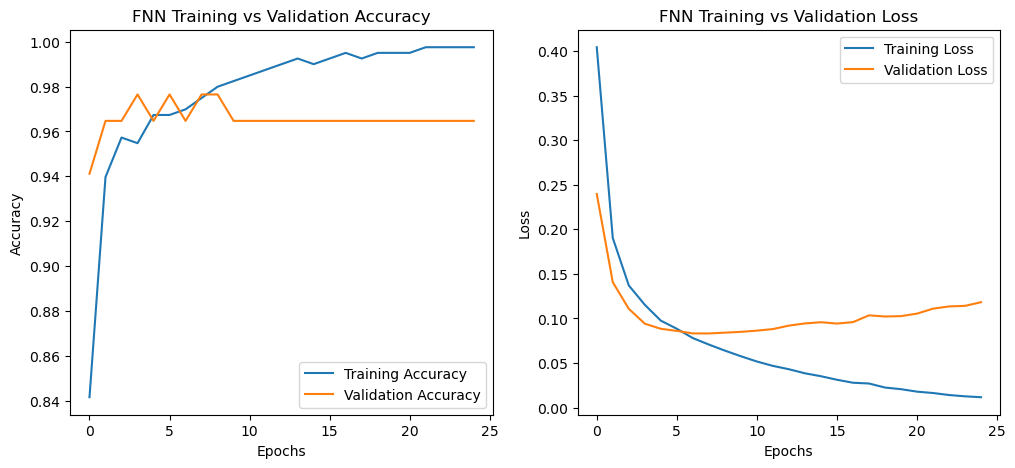

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [29]:
import matplotlib.pyplot as plt

# **Plot training history**
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('FNN Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('FNN Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **Predictions for FNN**
y_pred_FNN = (model2.predict(X_test) > 0.5).astype(int)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       1.00      0.97      0.98        32

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


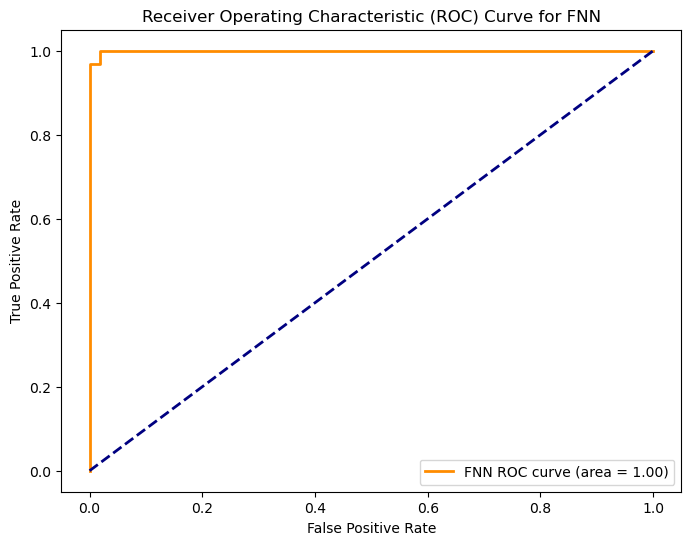

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import cross_val_score

# **Generate classification report**
print(classification_report(y_test, y_pred_FNN))

# **Calculate AUC and plot ROC Curve**
y_pred_proba_FNN = model2.predict(X_test).ravel()
fpr_FNN, tpr_FNN, _ = roc_curve(y_test, y_pred_proba_FNN)
roc_auc_FNN = auc(fpr_FNN, tpr_FNN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_FNN, tpr_FNN, color='darkorange', lw=2, label=f'FNN ROC curve (area = {roc_auc_FNN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for FNN')
plt.legend(loc="lower right")
plt.show()

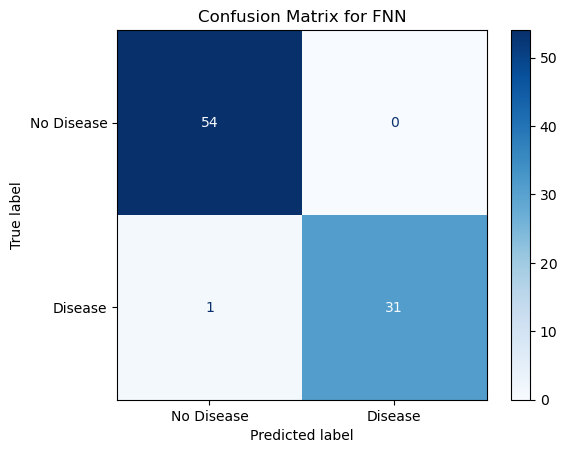

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# **Generate confusion matrix**
y_pred_FNN_labels = (y_pred_FNN > 0.5).astype(int)  # Convert probabilities to binary labels
cm_FNN = confusion_matrix(y_test, y_pred_FNN_labels)

disp_FNN = ConfusionMatrixDisplay(confusion_matrix=cm_FNN, display_labels=['Malignant', 'Benign'])
disp_FNN.plot(cmap='Blues')

plt.title('Confusion Matrix for FNN')
plt.show()